# Prédiction de la consommation totale d'énergie

<mark>Reste à faire :</mark>
* Vérifier que les colonnes s_u sont bien retirées
* mappage s_u_x sur son nom d'origine

# Chargement des données

Chargement des données nettoyées et préparées pour la modélisation :
* données aberrantes répertoriées et identifiées éliminés.
* retrait des variables non pertinentes.
* expansion des % de surface par usage.
* renommage des variables (noms plus concis).

Chargement et nettoyage

In [3]:
from pepper_commons import get_data
from seattle_commons import clean_dataset, drop_my_outliers
data = get_data()                                    # load data from CSV file
data, not_compliant, outliers = clean_dataset(data)  # drop outliers identified by Seattle
data, my_outliers = drop_my_outliers(data)           # drop my own outliers (18)
# display(data)

Extraction du sous-ensemble des données non résidentielles

In [4]:
from seattle_commons import get_family_buildings, get_business_buildings
# family = get_family_buildings(data)                # residential subset
data = get_business_buildings(data)                  # non residential subset
# display(data)

Préparation des données pour la modélisation

In [5]:
from seattle_commons import get_ml_data
ml_data = get_ml_data(data)
# display(ml_data)

# Partition et normalisation des données

Séparation entre variables caractéristiques et variables cibles.

Ciblage de `ie`, la consommation totale d'énergie rapportée à la surface du bâtiment.

In [6]:
from pepper_skl_commons import get_X_Y
X, Y = get_X_Y(ml_data)
y = Y.ie
# display(X); display(Y); display(y)

Séparation entre jeux d'entraînement et jeu de test.

In [7]:
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.25) # 25 % pour le jeu de test

Normalisation, pour les modèles qui le nécessitent.

**NB** Les variables préfixées de `_` dénotent la version normalisée des données.

In [8]:
from pepper_skl_commons import scale_X
_X_train, _X_test = scale_X(X_train, X_test)
# display(_X_train); display(_X_test)

Ce qui précède est là pour la démonstration.

En pratique, La préparation des données puis leur manipulation (packing) sont réalisées à l'aide de la classe `Dataset`.

In [9]:
from pepper_skl_commons import Dataset

random_state = 42
test_size = .25
dataset = Dataset(ml_data, 'all', random_state, test_size)

X = dataset._X_train
Y = dataset.Y_train
target = 'ie'
y = Y.ie

# Dummies

In [10]:
# baseline
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(dataset.X_train, y)

# score
import numpy as np
baseline_err = lr.score(dataset.X_test, dataset.Y_test.ie)
print(baseline_err)

0.3804566216754096


# OLS

Régression linéaire par les moins carrés ordinaires.

C'est aussi par ce modèle de base que l'on complète les dummies et qu'on présente le framework ML mis en place.

# Ridge

Régression linéaire pénalisée par la réduction de Tikhonov (norme $\ell_2$).

User Guide | [1.1.2. **Ridge**](https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification)

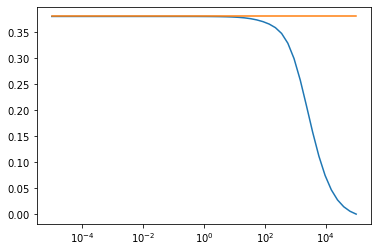

argmin : 49 ⇒ score : -0.00022616092536931198 ⇒ alpha : 100000.0


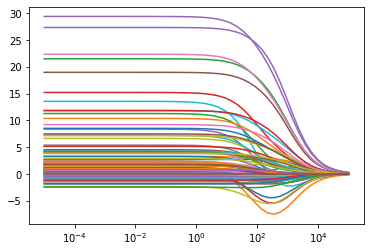

In [59]:
from sklearn import linear_model

import numpy as np
n_alphas = 50
alphas = np.logspace(-5, 5, 50)   # distribution logarithmique entre 10^-5 et 10^5

ridge = linear_model.Ridge()

coefs, scores = [], []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    scores.append(ridge.score(dataset._X_test, dataset.Y_test.ie)) #np.mean((ridge.predict(_X_test) - y_test) ** 2))

import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(alphas, scores, [10**-5, 10**5], [baseline_err, baseline_err])
ax.set_xscale('log')
plt.show()

# meilleur paramètre
i = np.argmin(scores)
score = scores[i]
print('argmin :', i, '⇒ score :', score, '⇒ alpha :', alphas[i])

# chemin de régularisation
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.show()

## Recherche des meilleurs paramètres

# Lasso

Régression linéaire pénalisée par norme $\ell_1$.

User Guide | [1.1.3. **Lasso**](https://scikit-learn.org/stable/modules/linear_model.html#lasso)

Meilleur paramètrage : $\alpha = 0,438 \Rightarrow R^2 = 0,382$

### Estimation des meilleurs paramètres

#### [Sélection de modèle Lasso à l'aide d'un critère d'information](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#selecting-lasso-via-an-information-criterion)

Cf. les deux critères implémentés par SKL :
* **AIC** *Akaike Information Criterion*
* **BIC** *Bayes Information Criterion*


Lasso IC selection for target ie


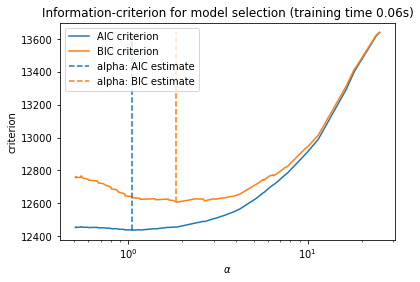

alpha: AIC estimate : 1.0458576410635378
alpha: BIC estimate : 1.8545714208090018


In [8]:
from pepper_commons import print_subtitle               # pretty print
from pepper_skl_commons import lasso_best_from_ic

best_alphas = dict()
best_alphas['aic'] = []
best_alphas['bic'] = []
print_subtitle(f'Lasso IC selection for target {target}')
_, alpha_aic, alpha_bic, _ = lasso_best_from_ic(X, y, show_tab=False, show_plot=True)
# _ ⇒ results, alpha_aic, alpha_bic, fit_time
best_alphas['aic'] += [alpha_aic]
best_alphas['bic'] += [alpha_bic]

#### [Sélection de modèle Lasso par validation croisée : descente de coordonnées](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#selecting-lasso-via-cross-validation)


Lasso CD CV selection for target ie


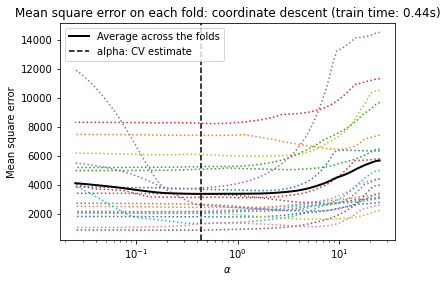

alpha: CD CV estimate : 0.43978440444985856


In [9]:
from pepper_skl_commons import lasso_best_from_cd_cv

best_alphas['cd_cv'] = []
print_subtitle(f'Lasso CD CV selection for target {target}')
y = Y[target]
alpha_, _, _, _, _ = lasso_best_from_cd_cv(X, y, show_tab=False, show_plot=True)
# _ ⇒  alpha_, mse_path_mean, alphas_, mse_path_, fit_time
best_alphas['cd_cv'] += [alpha_]

#### [Sélection de modèle Lasso par validation croisée : régression du moindre angle](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#selecting-lasso-via-cross-validation)


Lasso LARS CV selection for target ie


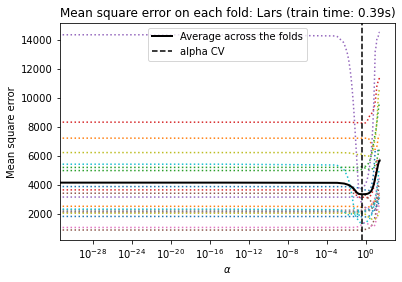

alpha: LARS VC estimate : 0.4234958729895697


In [10]:
from pepper_skl_commons import lasso_best_from_lars_cv

best_alphas['lars_cv'] = []
print_subtitle(f'Lasso LARS CV selection for target {target}')
y = Y[target]
alpha_, _, _, _, _ = lasso_best_from_lars_cv(X, y, show_tab=False, show_plot=True)
# _ ⇒  alpha_, mse_path_mean, alphas_, mse_path_, fit_time
best_alphas['lars_cv'] += [alpha_]

#### Synthèse

In [12]:
import pandas as pd
best_alphas_df = pd.DataFrame.from_dict(best_alphas)
best_alphas_df.index = [target]
display(best_alphas_df)

,aic,bic,cd_cv,lars_cv
ie,1.045858,1.854571,0.439784,0.423496


### Recherche des paramètres optimaux

In [50]:
from sklearn import linear_model
import numpy as np
from pepper_skl_commons import search_best_params

model = linear_model.Lasso
param_grid = {'alpha': np.linspace(.2, 2, 1000)}
scores, best_params, best_score, nested_score, cv_results = \
    search_best_params(dataset, target, model, param_grid, cv=10, verbose=False, scale=True)

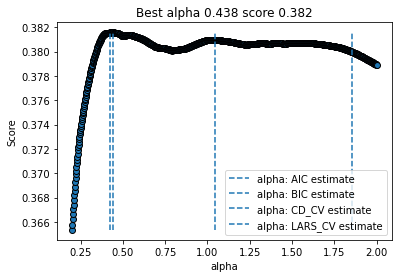

In [51]:
import matplotlib.pyplot as plt
def plot_alpha_score(est_alpha, alphas, scores, best_alpha, best_score):
    fig, ax = plt.subplots()
    ax.scatter(alphas, scores, edgecolors=(0, 0, 0))
    for c in est_alpha.columns:
        ax.vlines(
            est_alpha[c][0],
            scores.min(),
            scores.max(),
            label=f"alpha: {c.upper()} estimate",
            linestyle="--"
        )
    ax.set_xlabel("alpha")
    ax.set_ylabel("Score")
    ax.set_title(f'Best alpha {round(best_alpha,3)} score {round(best_score, 3)}')
    ax.legend()
    plt.show()

est_alpha = best_alphas_df
alphas = cv_results.param_alpha
scores = cv_results.mean_test_score
best_alpha = best_params['alpha']
plot_alpha_score(est_alpha, alphas, scores, best_alpha, best_score)

# Elastic-Net

Mix "Ridge" et Lasso : régression linéaire pénalisée par une combinaison des normes $\ell_1$ et $\ell_2$.

User Guide | [1.1.5. **Elastic-Net**](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net)

Meilleur paramètrage : $... = ... \Rightarrow R^2 = 0,382$

### Chemins de régularisation Lasse et Elastic-Net

Computing regularization path using the lasso...
Computing regularization path using the positive lasso...
Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


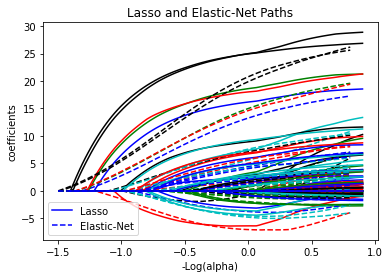

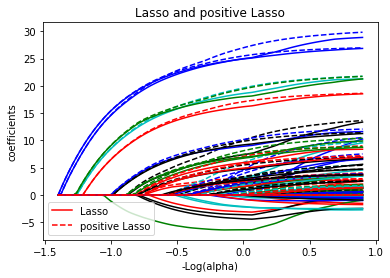

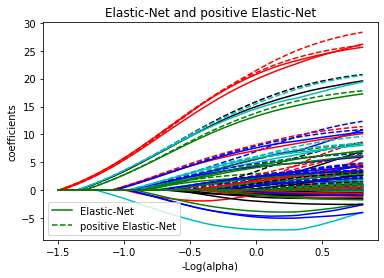

In [60]:
# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import lasso_path, enet_path
from sklearn import datasets

# Compute paths

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(
    X, y, eps=eps, positive=True
)
print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=0.8)

print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(
    X, y, eps=eps, l1_ratio=0.8, positive=True
)

# Display results

plt.figure(1)
colors = cycle(["b", "r", "g", "c", "k"])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle="--", c=c)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Lasso and Elastic-Net Paths")
plt.legend((l1[-1], l2[-1]), ("Lasso", "Elastic-Net"), loc="lower left")
plt.axis("tight")


plt.figure(2)
neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle="--", c=c)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Lasso and positive Lasso")
plt.legend((l1[-1], l2[-1]), ("Lasso", "positive Lasso"), loc="lower left")
plt.axis("tight")


plt.figure(3)
neg_log_alphas_positive_enet = -np.log10(alphas_positive_enet)
for coef_e, coef_pe, c in zip(coefs_enet, coefs_positive_enet, colors):
    l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)
    l2 = plt.plot(neg_log_alphas_positive_enet, coef_pe, linestyle="--", c=c)

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Elastic-Net and positive Elastic-Net")
plt.legend((l1[-1], l2[-1]), ("Elastic-Net", "positive Elastic-Net"), loc="lower left")
plt.axis("tight")
plt.show()

### Recherche des paramètres optimaux

In [11]:
from sklearn import linear_model
import numpy as np
from pepper_skl_commons import search_best_params

model = linear_model.ElasticNet
param_grid = {
    'alpha': np.logspace(-5, 5, 100),
    'l1_ratio': np.linspace(0.01, .99, 99),
    'random_state': [42],
    #'random_state': np.arange(40, 51),
    'max_iter': [10000]
}
scores, best_params, best_score, nested_score, cv_results = \
    search_best_params(dataset, target, model, param_grid, cv=10, verbose=True, scale=False)

ElasticNet estimation of ie ⇒ Searching best params among : {'alpha': array([1.00000000e-05, 1.26185688e-05, 1.59228279e-05, 2.00923300e-05,
       2.53536449e-05, 3.19926714e-05, 4.03701726e-05, 5.09413801e-05,
       6.42807312e-05, 8.11130831e-05, 1.02353102e-04, 1.29154967e-04,
       1.62975083e-04, 2.05651231e-04, 2.59502421e-04, 3.27454916e-04,
       4.13201240e-04, 5.21400829e-04, 6.57933225e-04, 8.30217568e-04,
       1.04761575e-03, 1.32194115e-03, 1.66810054e-03, 2.10490414e-03,
       2.65608778e-03, 3.35160265e-03, 4.22924287e-03, 5.33669923e-03,
       6.73415066e-03, 8.49753436e-03, 1.07226722e-02, 1.35304777e-02,
       1.70735265e-02, 2.15443469e-02, 2.71858824e-02, 3.43046929e-02,
       4.32876128e-02, 5.46227722e-02, 6.89261210e-02, 8.69749003e-02,
       1.09749877e-01, 1.38488637e-01, 1.74752840e-01, 2.20513074e-01,
       2.78255940e-01, 3.51119173e-01, 4.43062146e-01, 5.59081018e-01,
       7.05480231e-01, 8.90215085e-01, 1.12332403e+00, 1.41747416e+00,
       

In [1]:
def unpack_item(s, key):
    return s.apply(lambda x: x[key]).values

# graphique 3D score = f(random_state, test_size)
def surf3d_score_p1_p2(cv_results, tgt_label, param_1st, param_2nd):
    #scores = all_scores[all_scores.dataset == dataset_label]

    x = cv_results[param_1st]   # unpack_item(scores.params, 'random_state')
    y = cv_results[param_2nd]   # unpack_item(scores.params, 'test_size')

    # on réduit les scores à l'intervalle -1, 1 : les résultat contreperformants < -.25 sont ramenés à -.25
    test_scores = scores['mean_test_score'].copy()
    test_scores[test_scores < -.25] = -.25
    z = test_scores.values

    # voir https://stackoverflow.com/questions/21161884/plotting-a-3d-surface-from-a-list-of-tuples-in-matplotlib
    #from mpl_toolkits.mplot3d import Axes3D
    from scipy.interpolate import griddata
    import matplotlib.pyplot as plt
    import numpy as np

    grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
    grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(projection="3d")
    fig.add_axes(ax)

    surf = ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.plasma)

    ax.set_xlabel(param_1st)
    ax.set_ylabel(param_2nd)
    ax.set_zlabel('test_score')

    # pretty init view
    ax.view_init(elev=22, azim=110)
    plt.colorbar(surf)
    plt.suptitle(f'{tgt_label} test scores depending on {param_1st} and {param_2nd}')
    plt.subplots_adjust(top=0.9)

    plt.show()

In [15]:
display(cv_results.sort_values(by='rank_test_score'))
surf3d_score_p1_p2(cv_results, 'ie', 'param_alpha', 'param_l1_ratio')
# Surface 3D...

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_l1_ratio,param_max_iter,param_random_state,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
29,0.012700,0.002451,0.003101,0.000832,0.001668,0.8,10000,42,"{'alpha': 0.0016681005372000592, 'l1_ratio': 0...",0.314821,...,0.472369,0.552878,0.108030,0.449238,0.505750,0.412710,0.228257,0.378743,0.133061,1
10,0.045500,0.007724,0.002800,0.000748,0.000129,0.2,10000,42,"{'alpha': 0.0001291549665014884, 'l1_ratio': 0...",0.297747,...,0.461476,0.546950,0.086096,0.449040,0.558400,0.443965,0.235841,0.377790,0.141377,2
11,0.040105,0.004504,0.003496,0.000670,0.000129,0.266667,10000,42,"{'alpha': 0.0001291549665014884, 'l1_ratio': 0...",0.296927,...,0.460770,0.545751,0.085135,0.448579,0.560023,0.444457,0.236873,0.377249,0.141452,3
12,0.043599,0.005389,0.003103,0.000697,0.000129,0.333333,10000,42,"{'alpha': 0.0001291549665014884, 'l1_ratio': 0...",0.296083,...,0.460033,0.544359,0.084159,0.448010,0.561471,0.444862,0.238062,0.376585,0.141464,4
28,0.011399,0.001562,0.002704,0.000783,0.001668,0.733333,10000,42,"{'alpha': 0.0016681005372000592, 'l1_ratio': 0...",0.319331,...,0.474804,0.548473,0.116645,0.446108,0.482993,0.396437,0.230181,0.376431,0.128386,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.004200,0.000400,0.002000,0.000446,599.48425,0.466667,10000,42,"{'alpha': 599.4842503189421, 'l1_ratio': 0.466...",-0.003077,...,-0.004871,-0.017564,-0.003511,-0.016900,-0.000048,-0.069615,-0.012054,-0.016746,0.019549,72
73,0.005200,0.001536,0.003101,0.000944,599.48425,0.4,10000,42,"{'alpha': 599.4842503189421, 'l1_ratio': 0.4, ...",-0.003077,...,-0.004871,-0.017564,-0.003511,-0.016900,-0.000048,-0.069615,-0.012054,-0.016746,0.019549,72
72,0.004699,0.000899,0.002800,0.000749,599.48425,0.333333,10000,42,"{'alpha': 599.4842503189421, 'l1_ratio': 0.333...",-0.003077,...,-0.004871,-0.017564,-0.003511,-0.016900,-0.000048,-0.069615,-0.012054,-0.016746,0.019549,72
84,0.004300,0.000640,0.002299,0.000459,7742.636827,0.466667,10000,42,"{'alpha': 7742.636826811277, 'l1_ratio': 0.466...",-0.003077,...,-0.004871,-0.017564,-0.003511,-0.016900,-0.000048,-0.069615,-0.012054,-0.016746,0.019549,72


# Régression logistique